In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [ ]:
#%% abrir o datase de treino e teste

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
teste_sobrevivente = pd.read_csv('gender_submission.csv')

In [ ]:
#%% pre-processamento dos dados

#descrição estátistica das features núméricas
est = train.describe()

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [ ]:
#verificar valores nulos ou NAN
print(train.isnull().sum())

print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Irei criar um dataset que será a junção de teste e treino, para que eu possa fazer uma melhor analise e seleção das features

In [ ]:
train['test/train'] = 'train'
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,test/train
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [ ]:
test = test.merge(teste_sobrevivente)
test.insert(1,"survived",value=test["Survived"])
test.drop(columns="Survived",inplace=True)
test.rename(columns={"survived":"Survived"}, inplace=True)

test['test/train'] = "test"
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,test/train
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,test
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,test
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,test
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,test


In [ ]:
geral = pd.concat([train,test])

In [ ]:
geral.set_index('PassengerId', inplace = True)
geral.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,test/train
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [ ]:
def criar_features(X):
  subs = {'female':1, 'male':0}
  X['mulher'] = X['Sex'].replace(subs)

  X['Fare'] = X['Fare'].fillna(X['Fare'].mean())

  X['Age'] = X['Age'].fillna(X['Age'].mean())

  X['Embarked'] = X['Embarked'].fillna('S')

  subs = {'S':1, 'C':2, 'Q':3}
  X['porto'] = X['Embarked'].replace(subs)

  X['crianca'] = 1
  X['crianca'] = np.where(X['Age'] < 12, 1, 0)

  return X

geral = criar_features(geral)
geral.head()

<ipython-input-200-ea865f162487>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['mulher'] = X['Sex'].replace(subs)
<ipython-input-200-ea865f162487>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['porto'] = X['Embarked'].replace(subs)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,test/train,mulher,porto,crianca
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,0,1,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,1,2,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,1,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,1,1,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,0,1,0


Retirando as colunas que não serão nescessárias ou foram substituidas pelo metodo 'criar_features'

In [ ]:
geral.drop(columns = ['Name', 'Ticket', 'Cabin', 'Sex', 'Embarked'], inplace = True)
geral.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,test/train,mulher,porto,crianca
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,train,0,1,0
2,1,1,38.0,1,0,71.2833,train,1,2,0
3,1,3,26.0,0,0,7.9250,train,1,1,0
4,1,1,35.0,1,0,53.1000,train,1,1,0
5,0,3,35.0,0,0,8.0500,train,0,1,0


<Axes: >

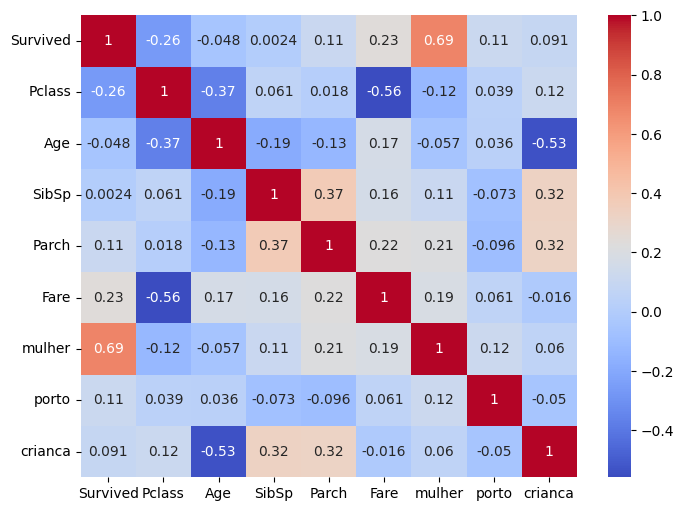

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(geral.drop(columns=['test/train']).corr(), annot=True, cmap='coolwarm')


A partir da matriz de correlação podemos selecionar melhor as features que serão utilizadas.

Obserservando os valores da matriz, descidi utilizar as features 'Pclass', 'mulher', 'porto' e 'Parch' pois são as que possuem os maiores valores de correlação com o alvo ('Survived')

In [ ]:
geral.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,test/train,mulher,porto,crianca
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,train,0,1,0
2,1,1,38.0,1,0,71.2833,train,1,2,0
3,1,3,26.0,0,0,7.9250,train,1,1,0
4,1,1,35.0,1,0,53.1000,train,1,1,0
5,0,3,35.0,0,0,8.0500,train,0,1,0


In [ ]:
features = ['Pclass', 'mulher', 'porto', 'Parch']
features_retiradas = ['Age', 'SibSp', 'Fare', 'crianca']
geral.drop(columns = features_retiradas, inplace = True)

In [ ]:
geral.isna().sum()

,0
Survived,0
Pclass,0
Parch,0
test/train,0
mulher,0
porto,0


In [ ]:
geral.head()

,Survived,Pclass,Parch,test/train,mulher,porto
PassengerId,,,,,,
1,0,3,0,train,0,1
2,1,1,0,train,1,2
3,1,3,0,train,1,1
4,1,1,0,train,1,1
5,0,3,0,train,0,1


In [ ]:
categoricas = ['Pclass', 'mulher', 'porto', 'Parch']

geral = pd.get_dummies(geral, columns = categoricas, drop_first = True, dtype=int)

In [ ]:
geral

,Survived,test/train,Pclass_2,Pclass_3,mulher_1,porto_2,porto_3,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
PassengerId,,,,,,,,,,,,,,
1,0,train,0,1,0,0,0,0,0,0,0,0,0,0
2,1,train,0,0,1,1,0,0,0,0,0,0,0,0
3,1,train,0,1,1,0,0,0,0,0,0,0,0,0
4,1,train,0,0,1,0,0,0,0,0,0,0,0,0
5,0,train,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,test,0,1,0,0,0,0,0,0,0,0,0,0
1306,1,test,0,0,1,1,0,0,0,0,0,0,0,0
1307,0,test,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_train = geral[geral["test/train"] == "train"]
df_test = geral[geral["test/train"] == "test"]

In [ ]:
train_x = df_train.drop(columns=["Survived","test/train"])
train_y = df_train["Survived"]

test_x = df_test.drop(columns=["Survived","test/train"])
test_y = df_test["Survived"]

print("train_x shape :",train_x.shape)
print("train_y shape :",train_y.shape)
print("test_X shape :",test_x.shape)
print("test_y shape :",test_y.shape)

train_x shape : (891, 12)
train_y shape : (891,)
test_X shape : (418, 12)
test_y shape : (418,)


In [ ]:
x = geral.drop(columns=["Survived","test/train"])
y = geral["Survived"]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logreg0 = LogisticRegression()
grid= {"C": np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg_cv = GridSearchCV(logreg0,grid,cv=10)
logreg_cv.fit(x,y)
print("Best parameters of Logistic Regression :",logreg_cv.best_params_)

Best parameters of Logistic Regression : {'C': 100.0, 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/u

In [ ]:
logreg = LogisticRegression(C=logreg_cv.best_params_["C"] , penalty=logreg_cv.best_params_["penalty"])
logreg.fit(train_x,train_y)
print("Logistic Regression Accuracy :",logreg.score(test_x,test_y))

Logistic Regression Accuracy : 0.9856459330143541


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = criar_features(train)
test = criar_features(test)


<ipython-input-102-ea865f162487>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['mulher'] = X['Sex'].replace(subs)
<ipython-input-102-ea865f162487>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['porto'] = X['Embarked'].replace(subs)
<ipython-input-102-ea865f162487>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_do

In [ ]:
#mapear as colunas
col = pd.Series(list(train.columns))

X_train = train.drop(['Survived'], axis = 1)

X_test = test.drop(['PassengerId'], axis = 1)


In [ ]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,mulher,porto,crianca
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,1,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1,2,0
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1,1,0
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,1,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,1,1,0
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,1,1,0
889,890,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,0,2,0


In [ ]:

#%% Selecionar as features

features = ['Pclass', 'mulher', 'porto', 'Parch']

X_train = X_train[features]
X_test = X_test[features]

y_train = train['Survived']



In [ ]:
X_train.head()

,Pclass,mulher,porto,Parch
0,3,0,1,0
1,1,1,2,0
2,3,1,1,0
3,1,1,1,0
4,3,0,1,0


In [ ]:
X_train.isna().sum()

,0
Pclass,0
mulher,0
porto,0
Parch,0


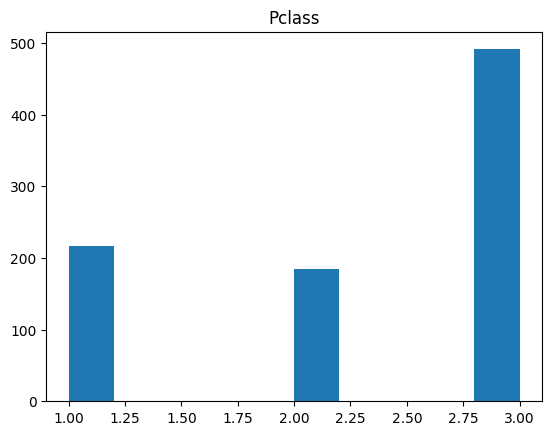

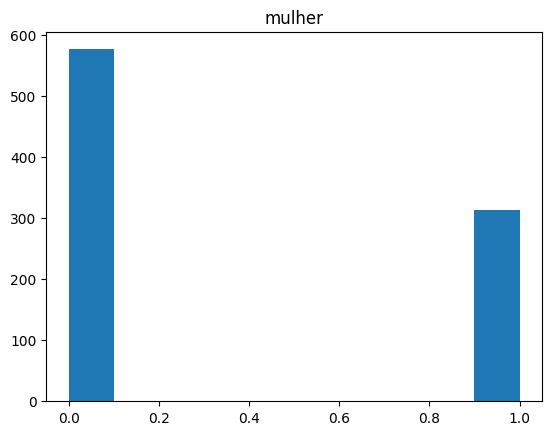

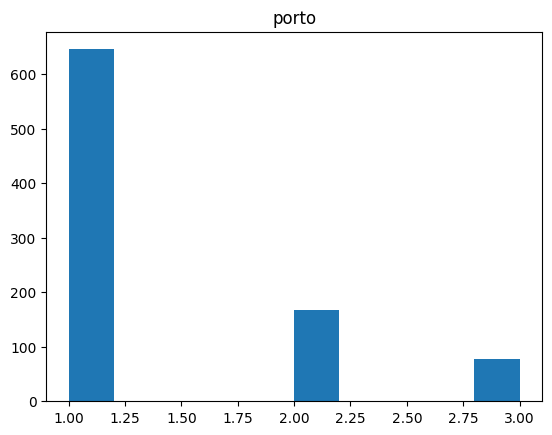

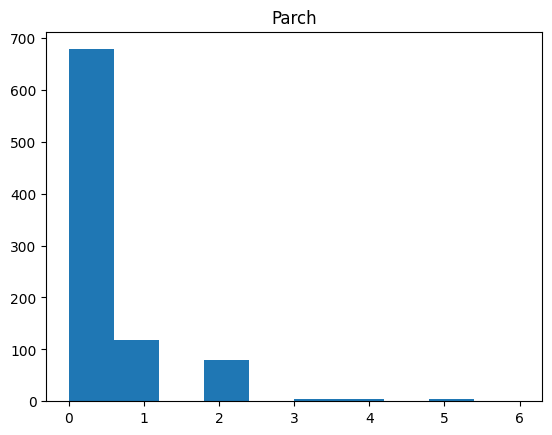

In [ ]:

#%% Visualização

import matplotlib.pyplot as plt

for i in X_train.columns:
    plt.hist(X_train[i])
    plt.title(i)
    plt.show()


Irei usar o 'get_dumies' para realizar a codificação one-hot em variáveis categóricas.

In [ ]:
categoricas = ['Pclass', 'mulher', 'porto', 'Parch']

X_train = pd.get_dummies(X_train, columns = categoricas, drop_first = True, dtype=int)
X_test = pd.get_dummies(X_test, columns = categoricas, drop_first = True, dtype=int)

In [ ]:
X_train.head()

,Pclass_2,Pclass_3,mulher_1,porto_2,porto_3,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0


In [ ]:

#%% Groupy

gp = train.groupby(['Survived']).count()


In [ ]:

#%% pivot_table

table = pd.pivot_table(train, index = ['Survived'], columns = ['Pclass'], values = 'PassengerId', aggfunc = 'count')



In [ ]:
X_train_sc = X_train
x_test_sc = X_test

In [ ]:
x_test_sc

,Pclass_2,Pclass_3,mulher_1,porto_2,porto_3,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9
0,0,1,0,0,1,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,0,0,0,0,0,0,0,0,0,0
414,0,0,1,1,0,0,0,0,0,0,0,0
415,0,1,0,0,0,0,0,0,0,0,0,0
416,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test = X_test.drop(['Pclass_3'], axis = 1)
Y_test = X_test.drop

In [ ]:
X_train_sc

,Pclass_2,Pclass_3,mulher_1,porto_2,porto_3,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,0,0,0,0,0,0,0,0,0
887,0,0,1,0,0,0,0,0,0,0,0
888,0,1,1,0,0,0,1,0,0,0,0
889,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
X_train_sc

,Pclass_2,Pclass_3,mulher_1,porto_2,porto_3,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,0,0,0,0,0,0,0,0,0
887,0,0,1,0,0,0,0,0,0,0,0
888,0,1,1,0,0,0,1,0,0,0,0
889,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
y_train

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [ ]:

#%% Padronização das variáveis

scaler = StandardScaler() #media 0 e desvio padrão 1

X_train_sc = scaler.fit_transform(X_train)

X_test_sc = scaler.transform(X_test)



In [ ]:
y_train

,Survived
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,0
889,1


In [ ]:
X_train_sc

,Pclass_2,Pclass_3,mulher_1,porto_2,porto_3,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,0,0,0,0,0,0,0,0,0
887,0,0,1,0,0,0,0,0,0,0,0
888,0,1,1,0,0,0,1,0,0,0,0
889,0,0,0,1,0,0,0,0,0,0,0


In [ ]:

#%% modelo e validação cruzada

#Logistic Regression
model_lr = LogisticRegression (C=100.0,  penalty= 'l2',random_state= 0 )

score = cross_val_score(model_lr, X_train_sc, y_train, cv = 10)

print(np.mean(score))

0.7800499375780274


In [ ]:

#%% Naive Bayes para Classificação

from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()

score = cross_val_score(model_nb, X_train_sc, y_train, cv = 10)

print(np.mean(score))

0.39169787765293385


In [ ]:

#%% KNN para classificação
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors= 5, p = 2)

score = cross_val_score(model_knn, X_train_sc, y_train, cv = 10)

print(np.mean(score))

0.7968539325842696


In [ ]:

#%% SVM para classificação
from sklearn.svm import SVC

model_svc = SVC(C = 1, kernel = 'rbf', degree = 2, gamma = 0.005, random_state=42)

score = cross_val_score(model_svc, X_train_sc, y_train, cv = 10)

print(np.mean(score))


0.786729088639201


In [ ]:

#%% Decision Tree

from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 2, min_samples_leaf = 1, random_state = 0)

score = cross_val_score(model_dt, X_train_sc, y_train, cv = 10)

print(np.mean(score))

0.7934831460674158


In [ ]:

#%% Random Forest

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_depth = 5, min_samples_split = 2, min_samples_leaf = 1, random_state = 0)

score = cross_val_score(model_rf, X_train_sc, y_train, cv = 10)

print(np.mean(score))


0.8035830212234705


In [ ]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.1 MB/s eta 0:00:00


In [ ]:

#%% Otimização de hiperparametros

from skopt import gp_minimize

def treinar_modelo_rf(parametros):

  model_rf = RandomForestClassifier(criterion = parametros[0], n_estimators = parametros[1], max_depth = parametros[2],
                                    min_samples_split = parametros[3], min_samples_leaf = parametros[4], random_state = 0, n_jobs = -1 )

  score = cross_val_score(model_rf, x, y, cv = 10)

  mean_score = np.mean(score)

  print(np.mean(score))

  return -mean_score

parametros = [('entropy', 'gini'),
              (100, 1000),
              (3, 20),
              (2, 10),
              (1, 10)]


otimos = gp_minimize(treinar_modelo_rf, parametros, random_state = 0, verbose = 1, n_calls = 30, n_random_starts = 10  )


print(otimos.fun, otimos.x)


Iteration No: 1 started. Evaluating function at random point.
0.8488549618320611
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 22.7068
Function value obtained: -0.8489
Current minimum: -0.8489
Iteration No: 2 started. Evaluating function at random point.
0.8480857310628303
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.3230
Function value obtained: -0.8481
Current minimum: -0.8489
Iteration No: 3 started. Evaluating function at random point.
0.8488549618320611
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.6443
Function value obtained: -0.8489
Current minimum: -0.8489
Iteration No: 4 started. Evaluating function at random point.
0.8480857310628303
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.1846
Function value obtained: -0.8481
Current minimum: -0.8489
Iteration No: 5 started. Evaluating function at random point.
0.8488549618320611
Iteration No: 5 ended. Evaluation done at random point.
Time

In [ ]:
def treinar_modelo_dt(paramentros):
  model_dt = DecisionTreeClassifier(criterion = paramentros[0], max_depth = paramentros[1], min_samples_split = paramentros[2],
                                    min_samples_leaf = paramentros[3], random_state = 0)
  score = cross_val_score(model_dt, x, y, cv = 10)

  mean_score = np.mean(score)

  print(np.mean(score))

  return -mean_score

parametros_dt = [('entropy', 'gini','log_loss'),
              (3, 30),
              (2, 20),
              (1, 20)]

# Otimização
otimos_dt = gp_minimize(
    treinar_modelo_dt,
    parametros_dt,
    random_state=0,
    verbose=1,
    n_calls=60, # O valor começa a estabilizar em aproximadamente 30 chamadas, porém deixei este valor pois com ele podemos obter uma pequenha melhora
    n_random_starts=10,
)

# Imprimir os melhores hiperparâmetros e o desempenho
print(otimos_dt.fun, otimos_dt.x)

Iteration No: 1 started. Evaluating function at random point.
0.8496124486200822
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2160
Function value obtained: -0.8496
Current minimum: -0.8496
Iteration No: 2 started. Evaluating function at random point.
0.8480798590722255
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2483
Function value obtained: -0.8481
Current minimum: -0.8496
Iteration No: 3 started. Evaluating function at random point.
0.8496124486200822
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2121
Function value obtained: -0.8496
Current minimum: -0.8496
Iteration No: 4 started. Evaluating function at random point.
0.8496124486200822
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.4365
Function value obtained: -0.8496
Current minimum: -0.8496
Iteration No: 5 started. Evaluating function at random point.
0.8496124486200822
Iteration No: 5 ended. Evaluation done at random point.
Time ta

In [ ]:
from skopt import gp_minimize
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

def treinar_modelo_svc(params):
  """Função objetivo para otimizar hiperparâmetros do SVC."""
  C, gamma = params
  modelo_svc = SVC(C=C, gamma=gamma, random_state=42)
  score = cross_val_score(modelo_svc, X_train_sc, y_train, cv=10)  # Substitua X_train_sc e y_train pelos seus dados
  return -np.mean(score)

In [ ]:
from skopt.space import Integer, Categorical

espaco_busca = [
    Integer(1, 7, name='C'),  # C de 1 a 7 (inteiros)
    Categorical([0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5], name='gamma')
]

In [ ]:
resultados = gp_minimize(treinar_modelo_svc, espaco_busca, n_calls=50, random_state=42)

In [ ]:
resultados

          fun: -0.8046941323345818
            x: [1, 1]
    func_vals: [-6.162e-01 -7.879e-01 ... -7.867e-01 -7.867e-01]
      x_iters: [[6, 0.0001], [6, 0.05], [4, 5e-05], [4, 0.001], [2, 0.05], [1, 0.1], [7, 1e-05], [7, 0.05], [5, 1e-05], [1, 0.01], [5, 5], [1, 0.0005], [1, 5], [1, 1], [7, 1], [5, 5e-05], [7, 5], [1, 0.0005], [7, 0.01], [2, 1e-05], [6, 5], [7, 0.1], [1, 0.001], [7, 0.001], [6, 0.1], [6, 0.005], [5, 1e-05], [3, 0.005], [4, 0.05], [4, 0.01], [4, 0.001], [2, 0.01], [6, 5e-05], [2, 0.0005], [3, 0.001], [5, 0.01], [2, 0.5], [1, 0.0001], [7, 0.0005], [6, 0.0005], [3, 0.05], [1, 0.5], [5, 0.05], [1, 0.005], [4, 0.1], [4, 0.005], [3, 0.1], [5, 5e-05], [2, 0.05], [2, 0.01]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        normalize_y=True, random_state

In [ ]:
def treinar_modelo_svc(parametros):
    model_svc = SVC(
        C=parametros[0],
        kernel=parametros[1],
        degree=parametros[2],
        gamma=parametros[3],
        random_state=42,
    )
    score = cross_val_score(model_svc, x, y, cv=10)
    mean_score = np.mean(score)
    print(mean_score)  # Imprimir para acompanhamento
    return -mean_score  # Minimizar

# Espaço de busca para hiperparâmetros do SVC
parametros_svc = [
    (1, 3, "log-uniform"),  # C
    ("linear", "poly", "rbf", "sigmoid"),  # kernel
    (1, 5),  # degree (apenas para kernel 'poly')
    ('scale', 'auto')  # gamma
]


# Otimização
otimos_svc = gp_minimize(
    treinar_modelo_svc,
    parametros_svc,
    random_state=0,
    verbose=1,
    n_calls=35,
    n_random_starts=10,
)

# Resultados
print(otimos_svc.fun, otimos_svc.x)

Iteration No: 1 started. Evaluating function at random point.
0.8549618320610687
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9829
Function value obtained: -0.8550
Current minimum: -0.8550
Iteration No: 2 started. Evaluating function at random point.
0.847328244274809
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5626
Function value obtained: -0.8473
Current minimum: -0.8550
Iteration No: 3 started. Evaluating function at random point.
0.8435055783910744
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5207
Function value obtained: -0.8435
Current minimum: -0.8550
Iteration No: 4 started. Evaluating function at random point.
0.8549618320610687
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.0433
Function value obtained: -0.8550
Current minimum: -0.8550
Iteration No: 5 started. Evaluating function at random point.
0.8549618320610687
Iteration No: 5 ended. Evaluation done at random point.
Time tak

In [ ]:
# Função objetivo para KNN
def treinar_modelo_knn(parametros):
    model_knn = KNeighborsClassifier(
        n_neighbors=parametros[0],
        p=parametros[1],
    )
    score = cross_val_score(model_knn, x, y, cv=10)
    mean_score = np.mean(score)
    print(mean_score)  # Imprimir para acompanhamento
    return -mean_score  # Minimizar


# Espaço de busca para hiperparâmetros do KNN
parametros_knn = [
    (5, 35),  # n_neighbors
    (1, 4) # p: power parameter for the Minkowski metric
]


# Otimização
otimos_knn = gp_minimize(
    treinar_modelo_knn,
    parametros_knn,
    random_state=0,
    verbose=1,
    n_calls=60,
    n_random_starts=10,
)

# Resultados
print(otimos_knn.fun, otimos_knn.x)

Iteration No: 1 started. Evaluating function at random point.
0.8388667058132707
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.5184
Function value obtained: -0.8389
Current minimum: -0.8389
Iteration No: 2 started. Evaluating function at random point.
0.8297005284791543
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5310
Function value obtained: -0.8297
Current minimum: -0.8389
Iteration No: 3 started. Evaluating function at random point.
0.8396300645918966
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3158
Function value obtained: -0.8396
Current minimum: -0.8396
Iteration No: 4 started. Evaluating function at random point.
0.8380916030534351
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3173
Function value obtained: -0.8381
Current minimum: -0.8396
Iteration No: 5 started. Evaluating function at random point.
0.8327363476218439
Iteration No: 5 ended. Evaluation done at random point.
Time ta

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [19, 4] before, using random point [25, 2]
  warnings.warn(


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.7824
Function value obtained: -0.8350
Current minimum: -0.8434
Iteration No: 43 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [18, 2] before, using random point [21, 3]
  warnings.warn(


0.8426834997064004
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.8879
Function value obtained: -0.8427
Current minimum: -0.8434
Iteration No: 44 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [19, 4] before, using random point [14, 4]
  warnings.warn(


0.8380916030534351
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.8606
Function value obtained: -0.8381
Current minimum: -0.8434
Iteration No: 45 started. Searching for the next optimal point.
0.8319847328244275


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [33, 1] before, using random point [26, 2]
  warnings.warn(


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.7580
Function value obtained: -0.8320
Current minimum: -0.8434
Iteration No: 46 started. Searching for the next optimal point.
0.8296829125073399
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.0239
Function value obtained: -0.8297
Current minimum: -0.8434
Iteration No: 47 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [29, 3] before, using random point [13, 3]
  warnings.warn(


0.8327363476218439
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.8539
Function value obtained: -0.8327
Current minimum: -0.8434
Iteration No: 48 started. Searching for the next optimal point.
0.8342689371697005


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [27, 3] before, using random point [12, 1]
  warnings.warn(


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.7769
Function value obtained: -0.8343
Current minimum: -0.8434
Iteration No: 49 started. Searching for the next optimal point.
0.8319788608338227


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [8, 3] before, using random point [32, 2]
  warnings.warn(


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.1246
Function value obtained: -0.8320
Current minimum: -0.8434
Iteration No: 50 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [11, 2] before, using random point [17, 2]
  warnings.warn(


0.838854961832061
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.3526
Function value obtained: -0.8389
Current minimum: -0.8434
Iteration No: 51 started. Searching for the next optimal point.
0.8373282442748092
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 1.4985
Function value obtained: -0.8373
Current minimum: -0.8434
Iteration No: 52 started. Searching for the next optimal point.
0.8350381679389314
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 1.0247
Function value obtained: -0.8350
Current minimum: -0.8434
Iteration No: 53 started. Searching for the next optimal point.
0.8319729888432178
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 0.8316
Function value obtained: -0.8320
Current minimum: -0.8434
Iteration No: 54 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [19, 4] before, using random point [34, 3]
  warnings.warn(


0.8312272460364063
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.9465
Function value obtained: -0.8312
Current minimum: -0.8434
Iteration No: 55 started. Searching for the next optimal point.
0.8403934233705226
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.9477
Function value obtained: -0.8404
Current minimum: -0.8434
Iteration No: 56 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [20, 2] before, using random point [9, 3]
  warnings.warn(


0.8319729888432178
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.9526
Function value obtained: -0.8320
Current minimum: -0.8434
Iteration No: 57 started. Searching for the next optimal point.
0.8327422196124485
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.9565
Function value obtained: -0.8327
Current minimum: -0.8434
Iteration No: 58 started. Searching for the next optimal point.
0.8297005284791543
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.9994
Function value obtained: -0.8297
Current minimum: -0.8434
Iteration No: 59 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [19, 4] before, using random point [20, 4]
  warnings.warn(


0.8403934233705226
Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 1.0340
Function value obtained: -0.8404
Current minimum: -0.8434
Iteration No: 60 started. Searching for the next optimal point.
0.8327422196124485
Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 0.8848
Function value obtained: -0.8327
Current minimum: -0.8434
-0.8434468584850265 [19, 2]


In [ ]:
# Função objetivo para Naive Bayes Gaussiano
def treinar_modelo_nb(parametros):
    model_nb = GaussianNB(var_smoothing=parametros[0])
    score = cross_val_score(model_nb, x, y, cv=10)
    mean_score = np.mean(score)
    print(mean_score)  # Imprimir para acompanhamento
    return -mean_score  # Minimizar


# Espaço de busca para hiperparâmetros do Naive Bayes Gaussiano
parametros_nb = [(1e-9, 1e-1, "log-uniform")]  # var_smoothing


# Otimização
otimos_nb = gp_minimize(
    treinar_modelo_nb,
    parametros_nb,
    random_state=0,
    verbose=1,
    n_calls=30,
    n_random_starts=10,
)

# Resultados
print(otimos_nb.fun, otimos_nb.x)

Iteration No: 1 started. Evaluating function at random point.
0.6585378743394011
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0856
Function value obtained: -0.6585
Current minimum: -0.6585
Iteration No: 2 started. Evaluating function at random point.
0.8197886083382266
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0808
Function value obtained: -0.8198
Current minimum: -0.8198
Iteration No: 3 started. Evaluating function at random point.
0.8281855549031121
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0886
Function value obtained: -0.8282
Current minimum: -0.8282
Iteration No: 4 started. Evaluating function at random point.
0.8197886083382266
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0810
Function value obtained: -0.8198
Current minimum: -0.8282
Iteration No: 5 started. Evaluating function at random point.
0.6928890193775691
Iteration No: 5 ended. Evaluation done at random point.
Time ta

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [0.004976954026962256]
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4456
Function value obtained: -0.8190
Current minimum: -0.8427
Iteration No: 14 started. Searching for the next optimal point.
0.40105108631826186


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [4.3035633675029585e-07]
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4047
Function value obtained: -0.4011
Current minimum: -0.8427
Iteration No: 15 started. Searching for the next optimal point.
0.3804403992953611


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.1] before, using random point [1.042429520303362e-08]
  warnings.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3686
Function value obtained: -0.3804
Current minimum: -0.8427
Iteration No: 16 started. Searching for the next optimal point.
0.8427363476218439
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3882
Function value obtained: -0.8427
Current minimum: -0.8427
Iteration No: 17 started. Searching for the next optimal point.
0.8396652965355255
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.3686
Function value obtained: -0.8397
Current minimum: -0.8427
Iteration No: 18 started. Searching for the next optimal point.
0.8427363476218439
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.3586
Function value obtained: -0.8427
Current minimum: -0.8427
Iteration No: 19 started. Searching for the next optimal point.
0.8396652965355255
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.3631
F

In [ ]:
# Função objetivo para Regressão Logística
def treinar_modelo_lr(parametros):
    model_lr = LogisticRegression(
        C=parametros[0],
        penalty=parametros[1],
        solver=parametros[2],
        max_iter=1000, # aumentar o número máximo de iterações
        random_state=0
    )
    score = cross_val_score(model_lr, x, y, cv=10)
    mean_score = np.mean(score)
    print(mean_score)  # Imprimir para acompanhamento
    return -mean_score  # Minimizar


# Espaço de busca para hiperparâmetros da Regressão Logística
parametros_lr = [
    (1e-3, 1e3, "log-uniform"),  # C: Inverse of regularization strength
    ('l1', 'l2'),  # penalty: Used to specify the norm used in the penalization
    ('liblinear', 'saga') # solver: Algorithm to use in the optimization problem
]


# Otimização
otimos_lr = gp_minimize(
    treinar_modelo_lr,
    parametros_lr,
    random_state=0,
    verbose=1,
    n_calls=40,
    n_random_starts=10,
)

# Resultados
print(otimos_lr.fun, otimos_lr.x)

Iteration No: 1 started. Evaluating function at random point.
0.8534351145038167
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3703
Function value obtained: -0.8534
Current minimum: -0.8534
Iteration No: 2 started. Evaluating function at random point.
0.8557251908396946
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1712
Function value obtained: -0.8557
Current minimum: -0.8557
Iteration No: 3 started. Evaluating function at random point.
0.8549618320610687
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1470
Function value obtained: -0.8550
Current minimum: -0.8557
Iteration No: 4 started. Evaluating function at random point.
0.8534351145038167
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1505
Function value obtained: -0.8534
Current minimum: -0.8557
Iteration No: 5 started. Evaluating function at random point.
0.8549618320610687
Iteration No: 5 ended. Evaluation done at random point.
Time ta

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.8557251908396946
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 3.6881
Function value obtained: -0.8557
Current minimum: -0.8557
Iteration No: 12 started. Searching for the next optimal point.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.8557251908396946
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 4.7620
Function value obtained: -0.8557
Current minimum: -0.8557
Iteration No: 13 started. Searching for the next optimal point.
0.6226130358191426
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4037
Function value obtained: -0.6226
Current minimum: -0.8557
Iteration No: 14 started. Searching for the next optimal point.
0.8549618320610687
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4483
Function value obtained: -0.8550
Current minimum: -0.8557
Iteration No: 15 started. Searching for the next optimal point.
0.8549618320610687
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.4985
Function value obtained: -0.8550
Current minimum: -0.8557
Iteration No: 16 started. Searching for the next optimal point.
0.8549618320610687
Iteration No: 16 ended. Search finished for the next optimal point.
T

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

0.8557251908396946
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 4.4312
Function value obtained: -0.8557
Current minimum: -0.8557
Iteration No: 31 started. Searching for the next optimal point.
0.8549618320610687
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.7683
Function value obtained: -0.8550
Current minimum: -0.8557
Iteration No: 32 started. Searching for the next optimal point.
0.8557251908396946
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.2836
Function value obtained: -0.8557
Current minimum: -0.8557
Iteration No: 33 started. Searching for the next optimal point.
0.8549618320610687
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.6127
Function value obtained: -0.8550
Current minimum: -0.8557
Iteration No: 34 started. Searching for the next optimal point.
0.8549618320610687
Iteration No: 34 ended. Search finished for the next optimal point.
T

In [ ]:
otimos_svc.x

[3, 'rbf', 1, 'auto']

In [ ]:
from operator import mod
modelo_svc = SVC(C = otimos_svc.x[0], kernel = otimos_svc.x[1], degree = otimos_svc.x[2], gamma = otimos_svc.x[3], random_state = 0)
modelo_knn = KNeighborsClassifier(n_neighbors= otimos_knn.x[0], p = otimos_knn.x[1])
modelo_rf = RandomForestClassifier(criterion = otimos.x[0], n_estimators = otimos.x[1], max_depth = otimos.x[2],
                                    min_samples_split = otimos.x[3], min_samples_leaf = otimos.x[4], random_state = 0, n_jobs = -1 )
modelo_lr = LogisticRegression (C = otimos_lr.x[0], penalty = otimos_lr.x[1], solver = otimos_lr.x[2], random_state= 0 )
modelo_dt = DecisionTreeClassifier(criterion = otimos_dt.x[0], max_depth = otimos_dt.x[1], min_samples_split = otimos_dt.x[2],
                                    min_samples_leaf = otimos_dt.x[3], random_state = 0)
modelo_nb = GaussianNB(var_smoothing=otimos_nb.x[0])

In [ ]:
X_test_sc

In [ ]:

#%% Ensanble model (Voting)
from sklearn.ensemble import VotingClassifier

model_voting = VotingClassifier(estimators = [('SVC', modelo_svc),('LR', modelo_lr),('DT', modelo_dt), ('NB', modelo_nb), ('KNN', modelo_knn), ('RF', modelo_rf) ], voting = 'hard')

model_voting.fit(x, y)

score = cross_val_score(model_voting, x, y, cv = 10)

y_pred = model_voting.predict(test_x)

submission = pd.DataFrame(test['PassengerId'])

submission['Survived'] = y_pred

submission.to_csv('submission_final-3.csv', index = False)

print(np.mean(score))


0.8534351145038167


In [ ]:
submission

In [ ]:
#%% modelo final

model_rf = RandomForestClassifier(criterion = otimos.x[0], n_estimators = otimos.x[1], max_depth = otimos.x[2],
                                    min_samples_split = otimos.x[3], min_samples_leaf = otimos.x[4], random_state = 0, n_jobs = -1 )

model_rf.fit(X_train_sc, y_train)

y_pred = model_rf.predict(X_train_sc)

mc = confusion_matrix(y_train, y_pred)
print(mc)

score = model_rf.score(X_train_sc, y_train)
print(score)

In [ ]:

#%% predição nos dados de teste

y_pred = model_voting.predict(X_test_sc)

submission = pd.DataFrame(test['PassengerId'])

submission['Survived'] = y_pred

submission.to_csv('submission5.csv', index = False)

In [ ]:
gender_submission = pd.read_csv('gender_submission.csv')
submission_final = pd.read_csv('submission_final-3.csv')

In [ ]:
merged_df = pd.merge(gender_submission, submission_final, on='PassengerId', suffixes=('_gender', '_final'))

In [ ]:
merged_df['Match'] = merged_df['Survived_gender'] == merged_df['Survived_final']

In [ ]:
num_matches = merged_df['Match'].sum()
print(f'Número de valores iguais: {num_matches}')
print(f"Taxa de acertos: {num_matches / merged_df.shape[0]}")

Número de valores iguais: 372
Taxa de acertos: 0.8899521531100478
